In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image
import torchvision.models as models
from torchvision.ops import generalized_box_iou_loss
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

from functools import partial

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from typing import Tuple, Dict, List
import sys
from timeit import default_timer as timer

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

IMG_SIZE = 224

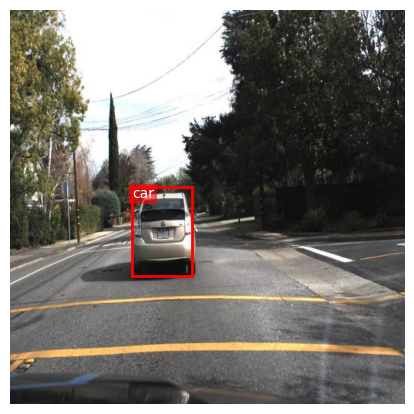

In [6]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None, file_pct=0.5)

train_data.show_with_box(index=53, color='r', label=True)

In [8]:
# for paper on VGG, see https://arxiv.org/abs/1409.1556
# we will stop after the conv53 layer
class VGG16_conv53(nn.Module):
    """
    Takes an input shape of (B, in_channels, IMG_SIZE, IMG_SIZE)
    Outputs a shape of (B, 512, IMG_SIZE/16, IMG_SIZE/16)
    """
    def __init__(self, in_channels: int = 3):
        super(VGG16_conv53, self).__init__()
        self.in_channels = in_channels
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),            # (B, in_channels, IMG_SIZE, IMG_SIZE) -> (B, 64, IMG_SIZE, IMG_SIZE)
            nn.BatchNorm2d(num_features=64), # (B, 64, IMG_SIZE, IMG_SIZE) -> (B, 64, IMG_SIZE, IMG_SIZE)
            nn.ReLU(),                       # (B, 64, IMG_SIZE, IMG_SIZE) -> (B, 64, IMG_SIZE, IMG_SIZE)
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),            # (B, 64, IMG_SIZE, IMG_SIZE) -> (B, 64, IMG_SIZE, IMG_SIZE)
            nn.BatchNorm2d(num_features=64), # (B, 64, IMG_SIZE, IMG_SIZE) -> (B, 64, IMG_SIZE, IMG_SIZE)
            nn.ReLU()                        # (B, 64, IMG_SIZE, IMG_SIZE) -> (B, 64, IMG_SIZE, IMG_SIZE)
        )

        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2) # (B, 64, IMG_SIZE, IMG_SIZE) -> (B, 64, IMG_SIZE/2, IMG_SIZE/2)

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 64, IMG_SIZE/2, IMG_SIZE/2) -> (B, 128, IMG_SIZE/2, IMG_SIZE/2)
            nn.BatchNorm2d(num_features=128), # (B, 128, IMG_SIZE/2, IMG_SIZE/2) -> (B, 128, IMG_SIZE/2, IMG_SIZE/2)
            nn.ReLU(),                        # (B, 128, IMG_SIZE/2, IMG_SIZE/2) -> (B, 128, IMG_SIZE/2, IMG_SIZE/2)
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 128, IMG_SIZE/2, IMG_SIZE/2) -> (B, 128, IMG_SIZE/2, IMG_SIZE/2)
            nn.BatchNorm2d(num_features=128), # (B, 128, IMG_SIZE/2, IMG_SIZE/2) -> (B, 128, IMG_SIZE/2, IMG_SIZE/2)
            nn.ReLU()                         # (B, 128, IMG_SIZE/2, IMG_SIZE/2) -> (B, 128, IMG_SIZE/2, IMG_SIZE/2)
        )

        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2) # (B, 128, IMG_SIZE/2, IMG_SIZE/2) -> (B, 128, IMG_SIZE/4, IMG_SIZE/4)

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 128, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.BatchNorm2d(num_features=256), # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.ReLU(),                        # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.BatchNorm2d(num_features=256), # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.ReLU(),                        # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.BatchNorm2d(num_features=256), # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
            nn.ReLU()                         # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/4, IMG_SIZE/4)
        )

        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2) # (B, 256, IMG_SIZE/4, IMG_SIZE/4) -> (B, 256, IMG_SIZE/8, IMG_SIZE/8)

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 256, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.BatchNorm2d(num_features=512), # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.ReLU(),                        # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.BatchNorm2d(num_features=512), # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.ReLU(),                        # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.BatchNorm2d(num_features=512), # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
            nn.ReLU()                         # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/8, IMG_SIZE/8)
        )

        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2) # (B, 512, IMG_SIZE/8, IMG_SIZE/8) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.BatchNorm2d(num_features=512), # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.ReLU(),                        # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.BatchNorm2d(num_features=512), # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.ReLU(),                        # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),             # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.BatchNorm2d(num_features=512), # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
            nn.ReLU()                         # (B, 512, IMG_SIZE/16, IMG_SIZE/16) -> (B, 512, IMG_SIZE/16, IMG_SIZE/16)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.mp1(x)
        x = self.layer2(x)
        x = self.mp2(x)
        x = self.layer3(x)
        x = self.mp3(x)
        x = self.layer4(x)
        x = self.mp4(x)
        x = self.layer5(x)
        return x

In [17]:
testimg = train_data[53][0].to(torch.float32).unsqueeze(dim=0)

print(f"test image shape: {testimg.shape}")
print(f"test image type: {testimg.dtype}")

test image shape: torch.Size([1, 3, 512, 512])
test image type: torch.float32


In [19]:
model = VGG16_conv53(in_channels=3)

test_output = model(testimg)

print(test_output.shape)

torch.Size([1, 512, 32, 32])


In [39]:
4*38*38 + 6*19*19 + 6*10*10 + 6*5*5 + 4*3*3 + 4*1*1

8732

In [ ]:
class SSD(nn.Module):
    def __init__(self, num_classes):
        super(SSD, self).__init__()
        self.num_classes = num_classes

        # Load the pre-trained VGG16 model
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.features = nn.ModuleList(vgg[:30])  # Use up to the conv5_3 layer

        # Additional layers for SSD
        self.extras = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(512, 1024, kernel_size=3, padding=1, dilation=1),     # (B, 1024, 19, 19)
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(256, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3),
                nn.ReLU(inplace=True)
            )
        ])

        # Localization and class prediction layers
        self.loc = nn.ModuleList([
            nn.Conv2d(512, 4 * 4, kernel_size=3, padding=1),   # 4 default boxes
            nn.Conv2d(1024, 6 * 4, kernel_size=3, padding=1),  # 6 default boxes
            nn.Conv2d(512, 6 * 4, kernel_size=3, padding=1),   # 6 default boxes
            nn.Conv2d(256, 6 * 4, kernel_size=3, padding=1),   # 6 default boxes
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=1),   # 4 default boxes
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=1)    # 4 default boxes
        ])

        self.conf = nn.ModuleList([
            nn.Conv2d(512, 4 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(1024, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(512, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=1)
        ])

    def forward(self, x):
        locs = []
        confs = []

        # Apply base network
        for k in range(len(self.features)):
            x = self.features[k](x)
        
        # Apply localization and confidence layers on conv4_3 and conv7
        locs.append(self.loc[0](x).permute(0, 2, 3, 1).contiguous())
        confs.append(self.conf[0](x).permute(0, 2, 3, 1).contiguous())

        for (i, layer) in enumerate(self.extras):
            x = layer(x)
            locs.append(self.loc[i+1](x).permute(0, 2, 3, 1).contiguous())
            confs.append(self.conf[i+1](x).permute(0, 2, 3, 1).contiguous())

        # Reshape and concatenate predictions
        locs = torch.cat([o.view(o.size(0), -1) for o in locs], 1)
        confs = torch.cat([o.view(o.size(0), -1) for o in confs], 1)

        locs = locs.view(locs.size(0), -1, 4)
        confs = confs.view(confs.size(0), -1, self.num_classes)

        return locs, confs

In [3]:

# Example usage
if __name__ == "__main__":
    num_classes = 21  # 20 classes + background
    ssd = SSD(num_classes)
    x = torch.randn(1, 3, 300, 300)
    locs, confs = ssd(x)
    print("Localization predictions:", locs.size())
    print("Confidence predictions:", confs.size())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\eblac/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.2MB/s] 


Localization predictions: torch.Size([1, 3916, 4])
Confidence predictions: torch.Size([1, 3916, 21])


In [25]:
x[0][0]

tensor([[ 1.5224, -0.0057,  1.9409,  ..., -0.9083, -0.4863, -0.0180],
        [-2.5733, -0.3840,  0.7026,  ...,  1.0849, -1.1229, -0.5213],
        [-0.1047, -0.2565,  0.2438,  ...,  0.7372, -1.4186, -0.3910],
        ...,
        [ 0.7367,  1.1022, -1.1998,  ...,  0.0436, -0.9206,  1.4853],
        [-0.1302, -0.1671, -0.2981,  ..., -0.2523, -0.2554,  0.9782],
        [-0.7261,  0.3441,  0.2698,  ..., -0.2807,  1.4267,  0.9253]])

In [26]:
locs

tensor([[[ 0.0620,  0.3038, -0.0212, -0.1289],
         [ 0.0406,  0.1038, -0.2696,  0.0390],
         [ 0.2433, -0.1950,  0.0420, -0.0091],
         ...,
         [-0.0071, -0.0124,  0.0214, -0.0078],
         [ 0.0007, -0.0196, -0.0251,  0.0086],
         [-0.0054, -0.0028, -0.0226,  0.0164]]], grad_fn=<ViewBackward0>)

In [27]:
confs

tensor([[[-0.1486,  0.1206,  0.0890,  ...,  0.0717, -0.4441,  0.0022],
         [-0.0716, -0.0479,  0.0571,  ...,  0.1282, -0.2270, -0.0632],
         [-0.1681,  0.2257,  0.2206,  ...,  0.0780,  0.0902, -0.0036],
         ...,
         [-0.0108,  0.0188,  0.0055,  ..., -0.0006,  0.0169, -0.0052],
         [ 0.0032, -0.0222,  0.0122,  ...,  0.0011,  0.0067,  0.0111],
         [-0.0110,  0.0185,  0.0113,  ..., -0.0139, -0.0060,  0.0193]]],
       grad_fn=<ViewBackward0>)

In [30]:
ssd.features

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
def forward(self, x):
        locs = []
        confs = []

        # Apply base network
        for k in range(len(self.features)):
            x = self.features[k](x)
        
        # Apply localization and confidence layers on conv4_3 and conv7
        locs.append(self.loc[0](x).permute(0, 2, 3, 1).contiguous())
        confs.append(self.conf[0](x).permute(0, 2, 3, 1).contiguous())

        for (i, layer) in enumerate(self.extras):
            x = layer(x)
            locs.append(self.loc[i+1](x).permute(0, 2, 3, 1).contiguous())
            confs.append(self.conf[i+1](x).permute(0, 2, 3, 1).contiguous())

        # Reshape and concatenate predictions
        locs = torch.cat([o.view(o.size(0), -1) for o in locs], 1)
        confs = torch.cat([o.view(o.size(0), -1) for o in confs], 1)

        locs = locs.view(locs.size(0), -1, 4)
        confs = confs.view(confs.size(0), -1, self.num_classes)

        return locs, confs

In [34]:
print(ssd.loc[0])
print(ssd.conf[0])

Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [36]:
ssd.extras

ModuleList(
  (0): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (3-4): 2 x Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
)

In [38]:
for (i, layer) in enumerate(ssd.extras):
    print(f"i: {i}  |  layer: {layer}")

i: 0  |  layer: Sequential(
  (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)
i: 1  |  layer: Sequential(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
)
i: 2  |  layer: Sequential(
  (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
)
i: 3  |  layer: Sequential(
  (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU(inplace=True)
)
i: 4  |  layer: Sequential(
  (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU(inplace=True)
)
